In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('paris_temperature.csv')

In [3]:
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Paris,France",2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,...,3.5,3,10,2023-10-01T07:49:34,2023-10-01T19:30:27,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999..."
1,"Paris,France",2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,...,4.4,4,10,2023-10-02T07:51:01,2023-10-02T19:28:21,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."
2,"Paris,France",2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,...,4.8,4,10,2023-10-03T07:52:29,2023-10-03T19:26:16,0.63,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"07149099999,07156099999,07146099999,LFPV,07157..."
3,"Paris,France",2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,...,5.1,4,10,2023-10-04T07:53:57,2023-10-04T19:24:10,0.66,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."
4,"Paris,France",2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,...,3.5,3,10,2023-10-05T07:55:25,2023-10-05T19:22:06,0.70,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Question 1

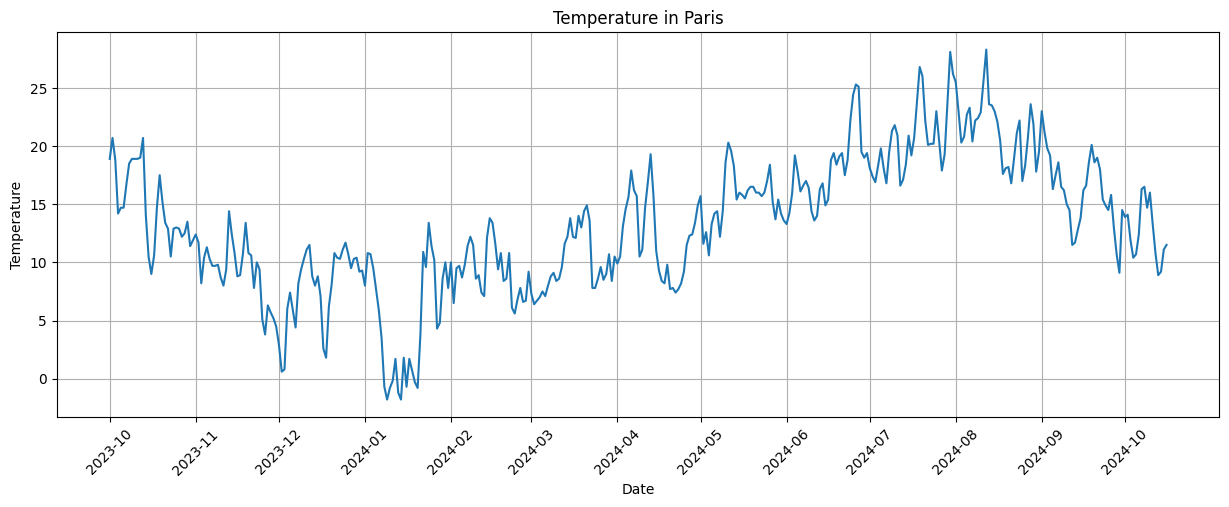

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temp'])
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.show()

# Question 3

In [6]:
numerical_features = []
categorical_features = []
date_features = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)
    elif df[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"There are {len(numerical_features)} numerical features: {numerical_features}")
print(f"There are {len(categorical_features)} categorical features: {categorical_features}")

There are 24 numerical features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
There are 8 categorical features: ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


In [7]:
df_numerical = df[numerical_features]
df_numerical.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,0.144,100.0,...,11.3,170.2,1023.7,46.5,18.6,39.8,3.5,3,10,0.57
2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,0.000,0.0,...,12.0,173.7,1018.8,48.6,16.8,51.3,4.4,4,10,0.60
2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,0.386,100.0,...,22.8,277.2,1020.5,71.8,22.1,54.5,4.8,4,10,0.63
2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,0.006,100.0,...,12.3,260.9,1029.8,62.0,22.4,58.9,5.1,4,10,0.66
2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,0.014,100.0,...,6.8,238.3,1027.3,82.3,21.3,41.7,3.5,3,10,0.70


# Question 4

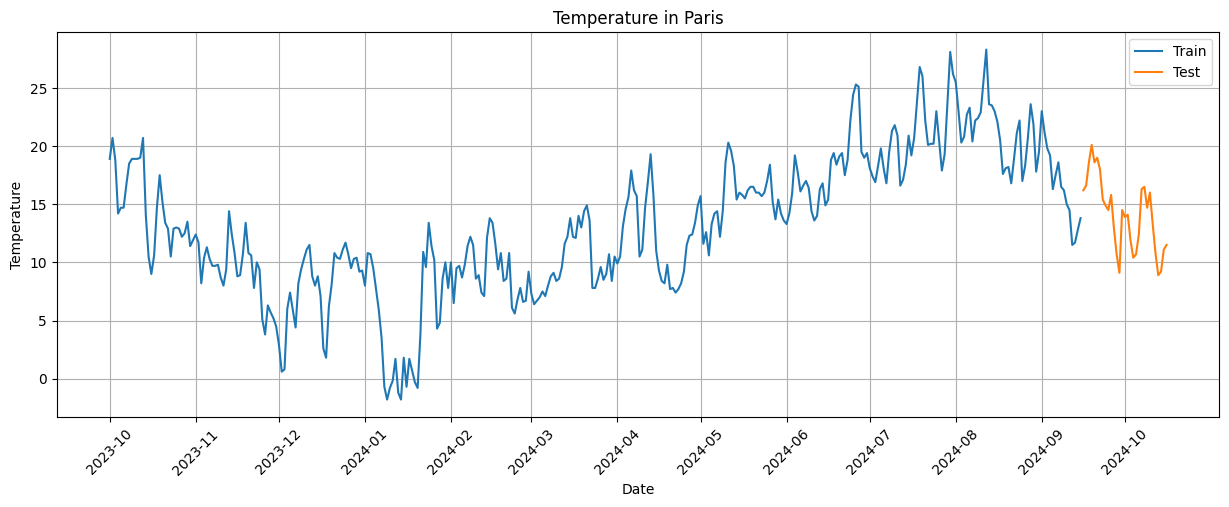

X_train shape: (351, 23), y_train shape: (351,)
X_test shape: (31, 23), y_test shape: (31,)


In [8]:
# scaler = MinMaxScaler()
# df_numerical[numerical_features] = scaler.fit_transform(df_numerical[numerical_features])
train_set = df_numerical[df_numerical.index <= pd.Timestamp('2024-09-15')]
test_set = df_numerical[df_numerical.index > pd.Timestamp('2024-09-15')]
plt.figure(figsize=(15, 5))
plt.plot(train_set.index, train_set['temp'], label='Train')
plt.plot(test_set.index, test_set['temp'], label='Test')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.legend()
plt.show()

X = df_numerical[['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 
                  'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 
                  'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 
                  'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 
                  'uvindex', 'severerisk', 'moonphase']].values

y = df_numerical['temp'].values

train_len = len(train_set)
X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Question 7
### (a) Applying LSTM model

In [9]:
def reshape_lstm_input(X, y, n_past):
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1))

    X_reshaped = []
    y_reshaped = []

    for i in range(n_past, len(X)):
        X_reshaped.append(X[i - n_past:i])
        y_reshaped.append(y[i])

    return np.array(X_reshaped), np.array(y_reshaped), scaler_X, scaler_y

n_past = 1
n_features = X_train.shape[1]

X_train_reshaped, y_train_reshaped, scaler_X, scaler_y = reshape_lstm_input(X_train, y_train, n_past)
X_test_reshaped, y_test_reshaped, _, _ = reshape_lstm_input(X_test, y_test, n_past)

if X_train_reshaped is not None and X_test_reshaped is not None:
    print("X_train_reshaped shape:", X_train_reshaped.shape)
    print("y_train_reshaped shape:", y_train_reshaped.shape)
    print("X_test_reshaped shape:", X_test_reshaped.shape)
    print("y_test_reshaped shape:", y_test_reshaped.shape)

X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_reshaped, dtype=torch.float32)

X_train_reshaped shape: (350, 1, 23)
y_train_reshaped shape: (350, 1)
X_test_reshaped shape: (30, 1, 23)
y_test_reshaped shape: (30, 1)


In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  
        return out

In [20]:
input_size = X_train_tensor.shape[2]
hidden_size = 50
num_layers = 4
output_size = 1
dropout_prob = 0.1
learning_rate = 0.001
num_epochs = 100
early_stopping_patience = 15
checkpoint_path = "best_model.pth"

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True
)

best_val_loss = float('inf')
no_improvement_epochs = 0
history = {"train_loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
 
    for i in range(len(X_train_tensor)):
        optimizer.zero_grad()
        outputs = model(X_train_tensor[i:i+1]) 
        loss = criterion(outputs, y_train_tensor[i:i+1])
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for i in range(len(X_test_tensor)):
            outputs = model(X_test_tensor[i:i+1])
            loss = criterion(outputs, y_test_tensor[i:i+1])
            epoch_val_loss += loss.item()

    train_loss = epoch_train_loss / len(X_train_tensor)
    val_loss = epoch_val_loss / len(X_test_tensor)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
  
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved to {checkpoint_path} with Val Loss: {best_val_loss:.4f}")
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered.")
        break


C:\Users\ADM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 0.0339, Val Loss: 0.0864
Model saved to best_model.pth with Val Loss: 0.0864
Epoch [2/100], Train Loss: 0.0132, Val Loss: 0.0815
Model saved to best_model.pth with Val Loss: 0.0815
Epoch [3/100], Train Loss: 0.0125, Val Loss: 0.0725
Model saved to best_model.pth with Val Loss: 0.0725
Epoch [4/100], Train Loss: 0.0116, Val Loss: 0.0590
Model saved to best_model.pth with Val Loss: 0.0590
Epoch [5/100], Train Loss: 0.0107, Val Loss: 0.0498
Model saved to best_model.pth with Val Loss: 0.0498
Epoch [6/100], Train Loss: 0.0081, Val Loss: 0.0336
Model saved to best_model.pth with Val Loss: 0.0336
Epoch [7/100], Train Loss: 0.0068, Val Loss: 0.0330
Model saved to best_model.pth with Val Loss: 0.0330
Epoch [8/100], Train Loss: 0.0059, Val Loss: 0.0300
Model saved to best_model.pth with Val Loss: 0.0300
Epoch [9/100], Train Loss: 0.0057, Val Loss: 0.0297
Model saved to best_model.pth with Val Loss: 0.0297
Epoch [10/100], Train Loss: 0.0055, Val Loss: 0.0311
Epoch [11/1

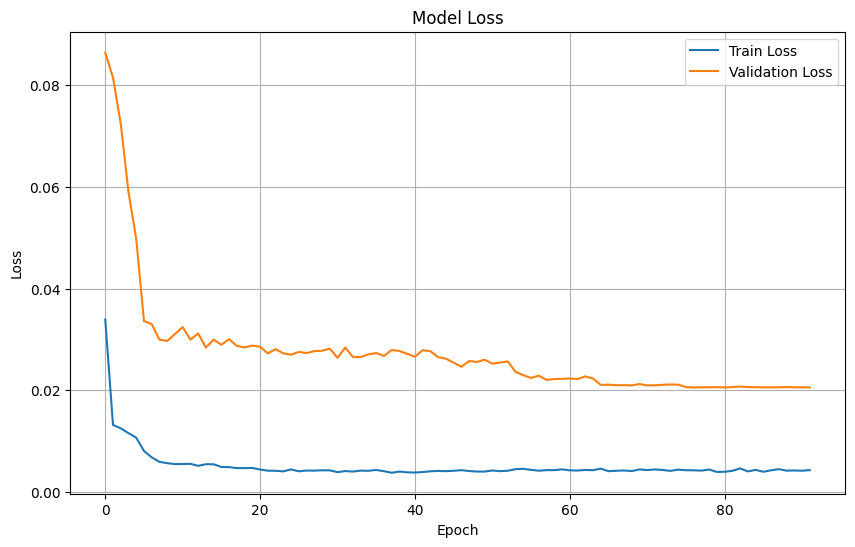

MAE: 3.5040
MSE: 18.6165
RMSE: 4.3147
R2 Score: 0.7343


In [21]:
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid()
plt.show()

with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    y_test_actual = y_test_tensor.numpy()
predictions = scaler_y.inverse_transform(predictions)
y_test_actual = scaler_y.inverse_transform(y_test_actual)
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

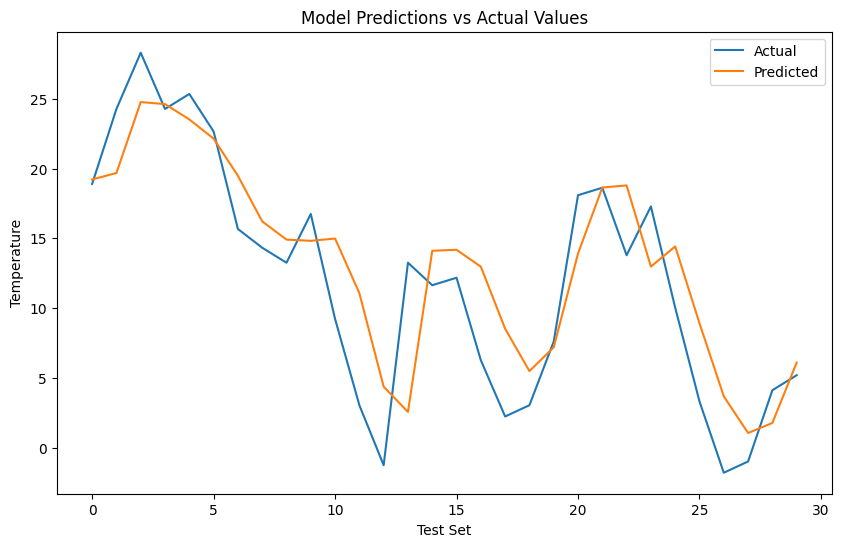

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title("Model Predictions vs Actual Values")
plt.xlabel("Test Set")
plt.ylabel("Temperature")
plt.show()